## Визуальный анализ данных выживших на Титанике.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

/tmp/ipykernel_19391/4044539684.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Титаник был крупнейшим пассажирским судном в 1912—1913 годах. Во время первого рейса затонул в северной Атлантике, столкнувшись с айсбергом в ночь с 14 на 15 апреля 1912 года, при этом погибло 1502 из 2224 пассажиров и членов экипажа. Данные о пассажирах были собраны в таблицы, которые можно скачать с <a href="https://www.kaggle.com/c/titanic/data" target="_blank">Kaggle</a>. Эти данные часто используются в качестве обучающих в анализе данных.

На дополнительном занятии 10 февраля будет показан простой пример работы с датасетом Титаник. Сейчас ваша задача &mdash; на основе простого анализа предоставленных данных обучить несколько классификаторов для определения выживших, иначе говоря, получить некоторые приближенные правила определения, выжил пассажир или нет, а также сравнить эти правила по качеству приближения.

#### 1. Подготовка данных

Загрузите данные с помощью `pandas`.

In [2]:
data = pd.read_csv("train.csv", index_col="PassengerId")
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Разделите данные по строкам на две части случайным образом в соотношении 7:3. Первую часть мы будем называть *обучающей*, а вторую &mdash; *тестовой*.

In [3]:
# train_features, train_target

train_indices = np.random.choice(
    len(data.index), int(7 * len(data.index) / 10), replace=False
)
test_indices = np.setdiff1d(np.arange(0, len(data.index)), train_indices)
train_data = data.iloc[train_indices]
test_data = data.iloc[test_indices]

Из каждой части оставим несколько признаков, с которыми мы будем работать, а также отдельно &mdash; целевой признак. Примените к обеим частям таблицы функцию ниже

In [4]:
features_columns = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
target_column = "Survived"  # Целевой признак


def get_features_and_target(data):
    features = data[features_columns]
    target = data[target_column]
    return features, target

In [5]:
train_features, train_target = get_features_and_target(data.iloc[train_indices])
test_features, test_target = get_features_and_target(data.iloc[test_indices])

#### 2. Исследование

**Внимание.** Эта часть задачи должна выполняться *исключительно на обучающих данных*. За использование тестовых данных решение не будет оценено.

Проведите визуальный анализ данных чтобы понять, как различные признаки влияют на целевой. Исследовать можно не целиком обучающие данные, а разделить их на две части по одному из признаков, а далее рассматривать каждую часть отдельно. 

*Не забывайте про информативность и эстетичность графиков.*


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Для начала найдём связь между ценой билета и его классом. Из графика видно, что чем больше номер билета - тем он дешевле (из графика справа убрали самые дорогие билеты)

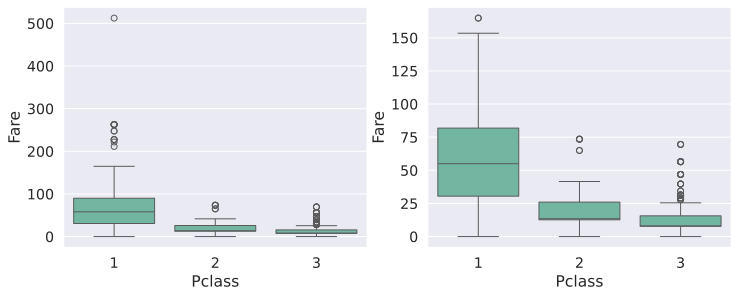

In [7]:
with sns.plotting_context(font_scale=0.5), sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 20))
    plt.subplot(4, 2, 1)
    sns.boxplot(data=train_data, x="Pclass", y="Fare")

    plt.subplot(4, 2, 2)
    sns.boxplot(data=train_data[train_data["Fare"] < 200], x="Pclass", y="Fare")

Построим распределения пассажиров по всем ключевым параметрам, разделяя их по тому, выжили они или нет, предварительно уберём небольшое число пассажиров с дорогими билетами и из больших семей. 

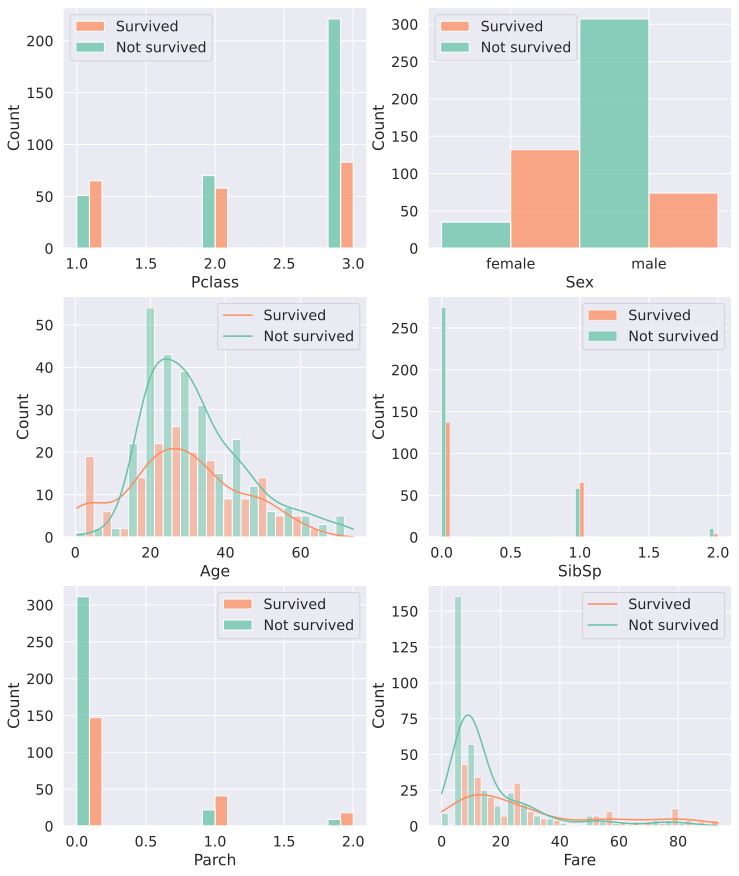

In [8]:
with sns.plotting_context(font_scale=0.5), sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 20))

    data_edited = train_data[
        (train_data["Fare"] < 100)
        & (train_data["SibSp"] < 3)
        & (train_data["Parch"] < 3)
    ]
    kde_need = ["Age", "Fare"]

    for i, column in enumerate(features_columns):
        plt.subplot(4, 2, i + 1)
        sns.histplot(
            data=data_edited,
            x=column,
            hue="Survived",
            kde=(column in kde_need),
            multiple="dodge",
        )
        plt.legend(labels=["Survived", "Not survived"])

Построим графики для оставшихся групп: пассажиры с самыми дорогими билетами, и пассажиры с большими семьями

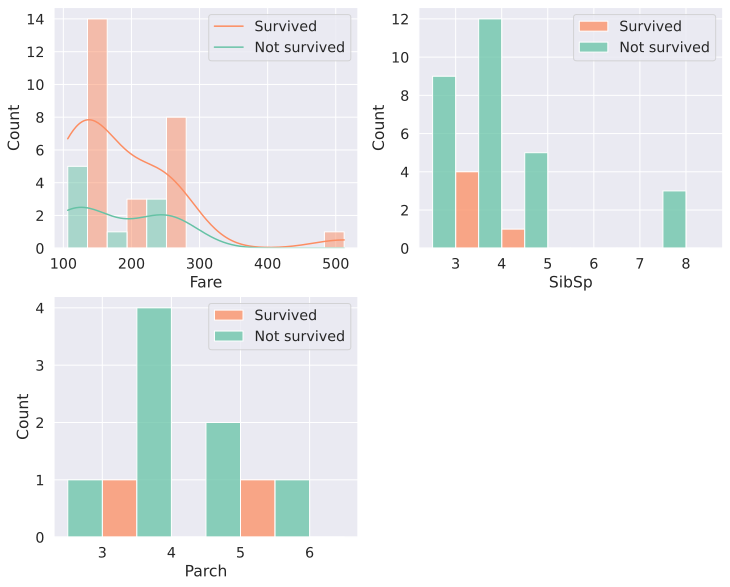

In [9]:
with sns.plotting_context(font_scale=0.5), sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 20))

    plt.subplot(4, 2, 1)
    sns.histplot(
        data=train_data[train_data["Fare"] >= 100],
        x="Fare",
        hue="Survived",
        kde=True,
        multiple="dodge",
    )
    plt.legend(labels=["Survived", "Not survived"])

    plt.subplot(4, 2, 2)
    sns.histplot(
        data=train_data[train_data["SibSp"] >= 3],
        x="SibSp",
        hue="Survived",
        multiple="dodge",
        discrete=True,
    )
    plt.legend(labels=["Survived", "Not survived"])

    plt.subplot(4, 2, 3)
    sns.histplot(
        data=train_data[train_data["Parch"] >= 3],
        x="Parch",
        hue="Survived",
        multiple="dodge",
        discrete=True,
    )
    plt.legend(labels=["Survived", "Not survived"])

Сразу можно заметить следующее: 

1) У пассажиров 3-го класса меньше шансов выжить. Это может быть связано с тем, что у них были дешёвые билеты и они находились в той части корабля, откуда нельзя было спастись

2) У пассажиров 1-го класса напротив, больше шансов спастись. Вероятно, их каюты были ближе к палубе.

2) Среди мужчин значительно больше погибших, а среди женщин и детей - выживших. Это может быть связано с тем, что в спасательные шлюпки в первую очередь сажали женщин и детей (до ~10-15 лет).

3) Меньше шансов выжить было у пассажиров без детей/родителей или братьев/сестёр/супругов.

4) Небольшое число пассажиров с самыми дорогими билетами имели высокие шансы спастись

5) Небольшое число пассажиров с самым большим количеством родственников второго ворядка (муж, жена, братья, сетры), напротив, имели меньшие шансы спастись

#### 3. Классификация методом ближайшего соседа

Ранее в контесте вы уже реализовали функцию поиска ближайших соседей. Теперь давайте применим ее для решения нашей текущей задачи. 

Реализуйте функцию, которая для каждого объекта тестового набора данных найдет $k$ ближайших соседей из обучающего набора данных, и в качестве ответа возьмет наиболее часто встречающееся значение целевого признака среди найденных соседей. Обратите внимание, что соседей необходимо искать только среди объектов обучающего набора данных.

In [10]:
def find_nearest_point(
    train: np.ndarray, features: np.ndarray, k: int
) -> np.ndarray:
    """
    Поиск k ближайших соседей для каждой точки (строчки) из features среди
    всех точек из train.
    Принимает записанные по строкам train и features точки
    Возвращает матрицу, в i-й строке k индексов близжайщих соседей features[i]
    """

    return (
        np.argsort(((features[:, np.newaxis, :] - train) ** 2).sum(axis=2))
    )[:, :k]

In [11]:
def knn(features, train_features, train_target, k=1):
    """
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    на основе обучающего набора данных train_features, train_target.
    Возвращает pandas.Series с теми же индексами, что и у features.
    Число k -- количество соседей.
    """

    weights = np.array([10, 35])

    nearest_indices = find_nearest_point(
        train_features[["Age", "Fare"]].values * weights,
        features[["Age", "Fare"]].values * weights,
        k,
    )

    count_survived = np.take(train_target.values, nearest_indices).sum(axis=1)

    prediction = (count_survived * 2 >= k).astype(int)

    return pd.Series(prediction, index=features.index)

Постройте классификатор методом ближайшего соседа, используя только признаки `Age` и `Fare`. 

Какую метрику (функцию расстояния) вы при этом используете? Нужно ли предварительно что-то сделать с признаками?

Я использовал обычную евклидовскую метрику с весами. На самом деле в использовании только этих двух признаках её должно быть достаточно в первом приближении: ширины разбросов для цен билетов и возраста (ширины отдельных основных холмиков в распределении) имеют порядок размера 10 долларов и 35 лет, поэтому веса должна усилить близость цен в нужной пропорции.

Рассмотрим распредение по этим двум признакам для основной массы пассажиров

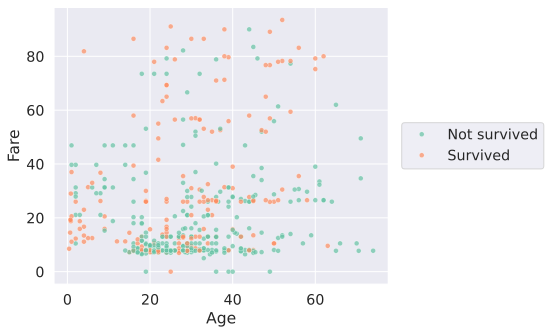

In [12]:
with sns.plotting_context(font_scale=0.2), sns.axes_style("darkgrid"):
    plt.figure(figsize=(6, 5))
    data_edited = train_data[(train_data["Fare"] < 100)]
    ax = sns.scatterplot(
        data=data_edited, x="Age", y="Fare", hue="Survived", s=25, alpha=0.7
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        ["Not survived", "Survived"],
        bbox_to_anchor=(1.04, 0.5),
        loc="center left",
        borderaxespad=0,
    )

Как видно из графика, в таких осях нет четких разделенных кластеров для выживших и не выживших, за исключением погибших среди пассажиров с самыми дешевыми билетами. Поэтому в любом случае этот метод будет иметь ограничения с таким выбором признаков. Возможно, если добавить другие признаки, то метод будет точнее.

Как меняется результат классификации при другом количестве соседей? Рассмотрите хотя бы три различных нечетных значения количества соседей.

Построим распределения для k = 3, 5, 7, 9 и посчитаем процент точного совпадения на тестирующей выборке:

Легенда гистограммы:

0 - какой процент совпадения на тестирующей выборке 

1 - какой процент умерших knn предсказала как выживших 

-1 - какой процент выживших knn предсказала как мертвых

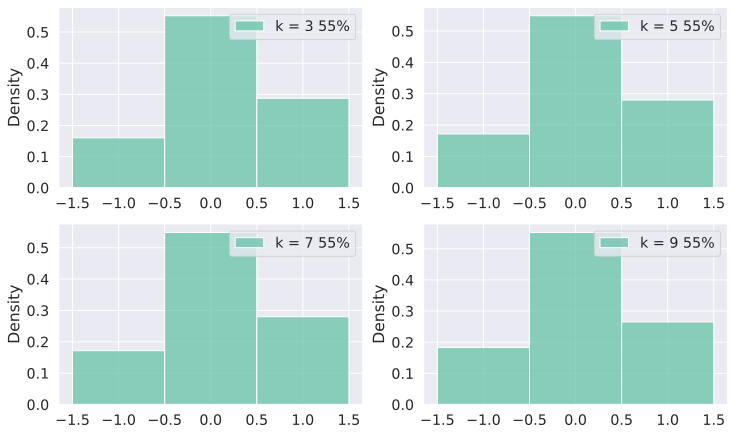

In [13]:
with sns.plotting_context(font_scale=0.5), sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 15))

    for i in range(4):
        plt.subplot(4, 2, i + 1)
        plot_data = (
            knn(test_data, train_features, train_target, 3 + 2 * i)
            - test_data["Survived"]
        )
        accuracy = int(round(np.sum(plot_data == 0) / len(plot_data), 2) * 100)
        sns.histplot(plot_data, multiple="dodge", discrete=True, stat="density")
        plt.legend(labels=["k = " + str(3 + 2 * i) + " " + str(accuracy) + "%"])

Как видно, в целом результат около 65%. (На самом здесь скачки в зависимости от выборки, от 60% до 70% при перезапуске)

Как можно было бы учесть другие признаки? Какие при этом могут возникнуть проблемы? 
...

Строить классификатор с другими признаками при этом не нужно.

Нужно учитывать то, что другие признаки имеют дискретные значения, соответственно выбор весов и метрики будет сложнее. 

Для пола, класса билета и порта посадки на Титаник (мы его откинули в самом начале) можно использовать дискретную метрику: 0 в случае совпадения признака, 1 иначе. Логика в том, что в этих признаках играет роль только случай совпадения, а если другое значение, то уже не так важно, какое именно. 

Для остальных признаков можно использовать евклидову метрику.

Заметим, что пол должен входить с большим весом, потому что перевес между выжившими женщинами и мужчинами значительный.

#### 5. Качество

Вспомним, что у нас имеется тестовая часть выборки. Самое время ее использовать для того, чтобы оценить, насколько хорошими получились деревья. Предложите какой-нибудь критерий качества.

*Замечание*. Не стоит пытаться искать, какие критерии существуют. В данном случае легко предложить адекватный критерий. Стандартные критерии мы разберем позже, но для начала лучше подумать самостоятельно.

**Критерий:**

Процент угадывания на тестирующей выборке.

Реализуйте данный критерий по шаблону

In [14]:
def criteria(target, predicted):
    accuracy = np.sum(predicted == target["Survived"]) / len(predicted)
    return accuracy

Оцените качество построенных kNN, используя предложенный критерий.

*Примечание.* Полученные значения не влияют на оценку по задание. Оценивается только корректность и обоснованность решения, а также графики и выводы.

Как видно было ранее, kNN дает точность около 60-70% при k от 3 до 9. В этом пункте рассмотрим k = 11

In [15]:
predictions = [
    knn(test_data, train_features, train_target, 11)
]


print(
    "kNN для k = 11 даёт точность: %0.3f" % criteria(test_data, predictions[0])
)

kNN для k = 11 даёт точность: 0.560


Посчитайте значение предложенного ранее критерия качества для метода ближайшего соседа для значений $k$ от 1 до 10. Постройте график зависимости критерия качества от $k$. Как вы можете пояснить полученные результаты?

Обратим внимание на следующее:

In [16]:
print(data.isna().sum())
print("Число пассажиров равно " + str(len(data)))

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Число пассажиров равно 891


Отсюда видно, что с пропусков в возрастах 177/891 ~ 20%, что довольно много. Проверим, влияет ли это на kNN. Для маленьких k:

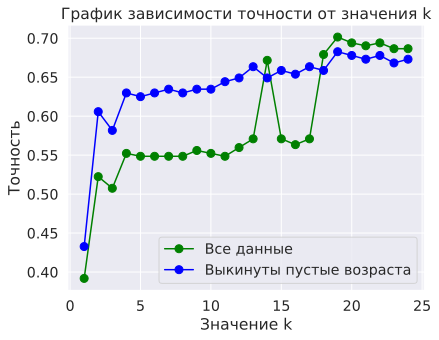

In [17]:
with sns.plotting_context(font_scale=0.5), sns.axes_style("darkgrid"):
    x = np.arange(1, 25)
    y = np.zeros_like(x).astype(float)
    z = np.zeros_like(x).astype(float)
    ed_data = test_data[test_data["Age"].notna()]
    ed_features = train_features[train_features["Age"].notna()]
    ed_target = train_target[ed_features.index]

    for k in range(len(x)):

        prediction = knn(test_data, train_features, train_target, k)
        y[k] = criteria(test_data, prediction)

        prediction = knn(ed_data, ed_features, ed_target, k)
        z[k] = criteria(ed_data, prediction)

    plt.plot(
        x,
        y,
        marker="o",
        markersize=8,
        color="green",
        linestyle="-",
        label="Все данные",
    )
    plt.plot(
        x,
        z,
        marker="o",
        markersize=8,
        color="blue",
        linestyle="-",
        label="Выкинуты пустые возраста",
    )
    plt.xlabel("Значение k")
    plt.ylabel("Точность")
    plt.title("График зависимости точности от значения k")
    plt.legend()
    plt.show()

Отсюда видно, что пустые возраста не особо влияют на kNN, в рамках погрешностей (при перезапуске синяя линия бывает выше и ниже зеленой). Для больших значений:

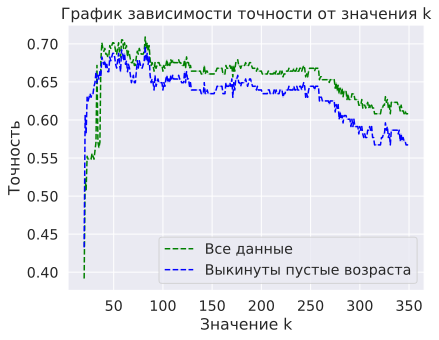

In [18]:
with sns.plotting_context(font_scale=0.5), sns.axes_style("darkgrid"):
    x = np.arange(20, 350)
    y = np.zeros_like(x).astype(float)
    z = np.zeros_like(x).astype(float)
    ed_data = test_data[test_data["Age"].notna()]
    ed_features = train_features[train_features["Age"].notna()]
    ed_target = train_target[ed_features.index]

    for k in range(len(x)):

        prediction = knn(test_data, train_features, train_target, k)
        y[k] = criteria(test_data, prediction)

        prediction = knn(ed_data, ed_features, ed_target, k)
        z[k] = criteria(ed_data, prediction)

    plt.plot(
        x,
        y,
        marker="o",
        markersize=0.1,
        color="green",
        linestyle="--",
        label="Все данные",
    )
    plt.plot(
        x,
        z,
        marker="o",
        markersize=0.1,
        color="blue",
        linestyle="--",
        label="Выкинуты пустые возраста",
    )
    plt.xlabel("Значение k")
    plt.ylabel("Точность")
    plt.title("График зависимости точности от значения k")
    plt.legend()
    plt.show()

При достаточно k влияние тоже мало.

Как видно, при маленьких k (особенно при k = 1) точность хуже, чем при больших. Объяснить это можно так: если смотреть на распределение пассажиров по возрасту и цене билета (график был выше) то видно, что чётких двух разных кластеров (выживших и невыживших) с явной границей нет, есть только небольшие кучи расположенных рядом точек. Поэтому при k = 1 возможно случайное попадание в рядом расположенную точку другого цвета. При больших k точность не очень меняется - мы просто выбираем цвет ближайшего небольшого кластера точек. Сильно улучшить точность ростом k не получится в силу тех же причин. При слишком больших k точность будет только хуже - потому что мы начинаем задевать соседние класетры.

#### 6. Выводы

Из анализа графиков распределений мы получили следующие выводы о выживании пассажиров:

1) У пассажиров 3-го класса меньше шансов выжить. Это может быть связано с тем, что у них были дешёвые билеты и они находились в той части корабля, откуда нельзя было спастись

2) У пассажиров 1-го класса напротив, больше шансов спастись. Вероятно, их каюты были ближе к палубе.

2) Среди мужчин значительно больше погибших, а среди женщин и детей - выживших. Это может быть связано с тем, что в спасательные шлюпки в первую очередь сажали женщин и детей (до ~10-15 лет).

3) Меньше шансов выжить было у пассажиров без детей/родителей или братьев/сестёр/супругов.

4) Небольшое число пассажиров с самыми дорогими билетами имели высокие шансы спастись

5) Небольшое число пассажиров с самым большим количеством родственников второго ворядка (муж, жена, братья, сетры), напротив, имели меньшие шансы спастись


Метод ближайшего соседа с евклидовой метрикой с весами в признаках (возраст, цена билета) дает достаточно высокую точность в 70% - и его можно усилить, если добавить сравнение по полу - потому что перевес для женщин и мужчин в выживании значительный, а так же другие признаки - достаточно весов и дискретной метрики. Возраста и цены билета понятно что не хватает - это уже видно из того, что в таких осях у нас в целом довольно близко расположены точки разных классов, нету раздельных кластеров с четкой границей.